In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd

In [2]:
train, test = tfds.load('movielens/latest-small-ratings', split=['train[:90%]', 'train[90%:]'])

In [3]:
df_train = tfds.as_dataframe(train)

2022-12-24 21:01:57.546904: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [4]:
df_train.head()

,movie_genres,movie_id,movie_title,timestamp,user_id,user_rating
0,"[7, 8, 13, 15]",b'4874',b'K-PAX (2001)',1446749868,b'105',5.0
1,"[7, 18]",b'527',"b""Schindler's List (1993)""",1305696664,b'17',4.5
2,"[5, 9]",b'7943',"b'Killers, The (1946)'",1166068511,b'309',4.0
3,"[10, 13, 16]",b'1644',b'I Know What You Did Last Summer (1997)',1518640852,b'111',0.5
4,"[1, 2, 3, 4, 12, 14]",b'8360',b'Shrek 2 (2004)',1127221149,b'182',3.0


In [4]:
len(df_train['user_id'].unique())

610

In [5]:
len(df_train['movie_id'].unique())

9362

In [6]:
unique_list_movies = df_train['movie_id'].unique()
unique_list_users = df_train['user_id'].unique()

reindex_movies = pd.DataFrame.from_dict({movie : i for i, movie in zip(range(len(unique_list_movies)),  unique_list_movies)}, orient='index')
reindex_users = pd.DataFrame.from_dict({user : i for i, user in zip(range(len(unique_list_users)),  unique_list_users)}, orient='index')


i1 = np.array(reindex_users.loc[df_train['user_id']]).flatten()
i2 = np.array(reindex_movies.loc[df_train['movie_id']]).flatten()
v  = np.array(df_train['user_rating'] / 5.0)


In [17]:
# first without sparse matrices

user_embedding = tf.Variable(tf.random_normal_initializer(mean=0.0, stddev=1.0)(shape=(len(unique_list_users), 10)), trainable=True)
movie_embedding = tf.Variable(tf.random_normal_initializer(mean=0.0, stddev=1.0)(shape=(10, len(unique_list_movies))), trainable=True)

result_matrix = np.zeros((len(unique_list_users), len(unique_list_movies)))
result_matrix[i1, i2] = v
result_matrix = tf.constant(result_matrix, dtype=tf.float32)

mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.005)

history = []
for i in range(0, 2000):
  with tf.GradientTape() as tape:
    mm = tf.matmul(user_embedding, movie_embedding)
    r = mse(mm, result_matrix)
    
  grad = tape.gradient(r, [user_embedding, movie_embedding])
  optimizer.apply_gradients(zip(grad, [user_embedding, movie_embedding]))

  history.append(r.numpy())


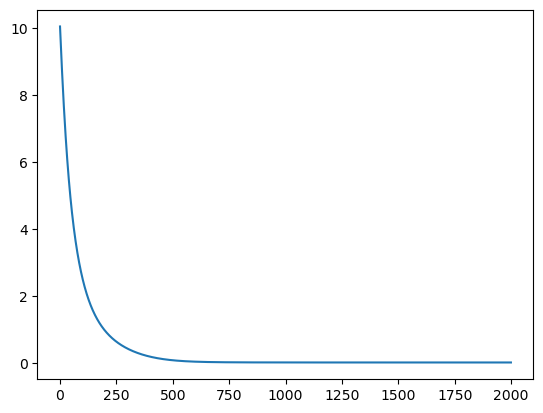

In [18]:
plt.plot(history)

In [19]:
def recommend(user):
  usere = tf.nn.embedding_lookup(user_embedding, [reindex_users.loc[user]])
  user_results = tf.nn.embedding_lookup(result_matrix, [reindex_users.loc[user]])                         
  v = tf.matmul(usere, movie_embedding)
  v = tf.subtract(v, user_results)

  reco = tf.math.argmax(v[0][0])
  reco = np.array(reindex_movies[reindex_movies[0] == reco].index)[0]

  return df_train[df_train['movie_id'] == reco]['movie_title'].iloc[0]

print(recommend(b'105'))


b'Toy Story (1995)'


In [26]:
# with sparse tensors, for better memory usage
# note, the two implementations , with sparse and with dense representations are not identical
# this one does not try to optimize 0s
# it is also faster by about 40%, despite the tf.gather used inside the loop

user_embedding = tf.Variable(tf.random_normal_initializer(mean=0.0, stddev=1.0)(shape=(len(unique_list_users), 10)), trainable=True)
movie_embedding = tf.Variable(tf.random_normal_initializer(mean=0.0, stddev=1.0)(shape=(10, len(unique_list_movies))), trainable=True)

sparse_results_matrix = tf.SparseTensor(np.vstack([i1, i2]).T, v, dense_shape=(len(unique_list_users), len(unique_list_movies)))
movie_indices = tf.gather(sparse_results_matrix.indices, 1, axis=1)
user_indices = tf.gather(sparse_results_matrix.indices, 0, axis=1)

@tf.function
def matmul_and_loss(user_embedding, movie_embedding):
  movie_embeddings_for_user_rated_movies = tf.transpose(tf.gather(movie_embedding, movie_indices, axis=1))
  this_user_embedding = tf.gather(user_embedding, user_indices, axis=0)

  our_results = tf.reduce_sum(
    tf.math.multiply(this_user_embedding, movie_embeddings_for_user_rated_movies),
    axis = 1
  )
  return tf.reduce_mean(tf.square(our_results - sparse_results_matrix.values))    

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
history = []
for i in range(0, 2000):
  
  with tf.GradientTape() as tape:
    mse = matmul_and_loss(user_embedding, movie_embedding)
    
  grad = tape.gradient(mse, [user_embedding, movie_embedding])
  optimizer.apply_gradients(zip(grad, [user_embedding, movie_embedding]))

  history.append(mse)

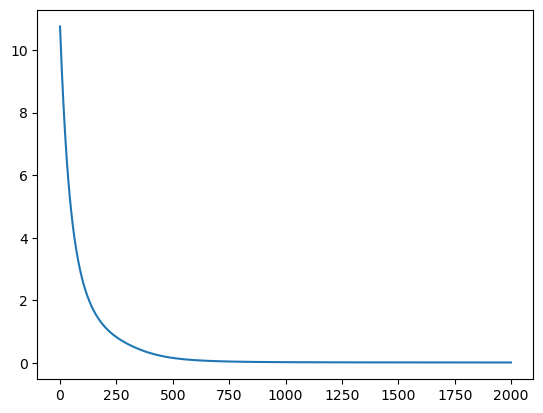

In [22]:
plt.plot(history)